In [1]:
%reset -f
import ROOT, numpy


ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetGridColor(16)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)
ROOT.gStyle.SetPadRightMargin(0.05)
ROOT.gStyle.SetPadLeftMargin(0.08)
ROOT.gStyle.SetTitleOffset(0.9, 'Y')


fname="../data/lvl2_eppi0.inb.mc.root"

dsid = 'inb' if 'inb' in fname else 'outb'


rdf = ROOT.RDataFrame("h22", fname)

rdf = rdf.Define("p","sqrt(px*px+py*py+pz*pz)")
rdf = rdf.Define("p0","sqrt(px0*px0+py0*py0+pz0*pz0)")
rdf = rdf.Define('dp','p0-p')
rdf = rdf.Define("th","atan2(sqrt(px*px+py*py),pz)*TMath::RadToDeg()")

rdf = rdf.Define("thp","th").Define("pp","p").Define("fip",'0')

Welcome to JupyROOT 6.24/06


In [2]:
rdf = rdf.Define("lowband", """
double dc1th = atan2(sqrt(dcx1*dcx1 + dcy1*dcy1), dcz1)*TMath::RadToDeg();
bool lowband = dc1th < (-53.14680163254601 + 79.61307254040804*pow(pp-0.3, 0.05739232362022314));

return lowband;
//return thp<27;
""")

SBcorrfile = "../code/sangbaek.eloss.inb.code" if 'inb' in fname else "../code/sangbaek.eloss.outb.code"
with open(SBcorrfile) as ff:
    SBelosscode = ff.read()

rdf = rdf.Define("dplossSB", SBelosscode+"""
return sqrt(pxSB*pxSB + pySB*pySB + pzSB*pzSB) - pp;
""")

grSB0 = rdf.Filter("lowband").Graph("pp","dplossSB")
grSB1 = rdf.Filter("!lowband").Graph("pp","dplossSB")

In [3]:
hpth = rdf.Histo2D(("hpth","polar angle vs momentum coverage for proton in MC;momentum;#theta [#circ]",200,0,4,200,0,50),"p","th")
hdpth = rdf.Histo2D(("hdpth","#Delta P vs polar angle;#theta [#circ];p_{gen}-p_{rec}",200,0,50,200,-0.071,0.1),"th","dp")
hdpth1 = rdf.Filter("p<0.7").Histo2D(("hdpth","#Delta P vs polar angle;#theta [#circ];p_{gen}-p_{rec}",200,0,50,200,-0.1,0.1),"th","dp")

h0 = rdf.Histo2D(("hdpp0","#Delta P vs momentum;momentum [GeV];#Delta p [GeV]",100,0,4,200,-0.071,0.1), "p0","dp")
h1 = rdf.Filter("lowband").Histo2D(("hdpp1","#theta<27#circ;momentum [GeV];#Delta p [GeV]",100,0,4,200,-0.02,0.02), "p0","dp")
h2 = rdf.Filter("!lowband").Histo2D(("hdpp2","#theta>27#circ;momentum [GeV];#Delta p [GeV]",100,0,4,200,-0.081,0.081), "p0","dp")
ths = numpy.arange(28, 39, 2)

fPC0 = ROOT.TF1("fPC0","pol2",0.4,2)
fPC0.SetParameters(0.0398946, -0.0748125, 0.0395764)
fPC0.SetLineStyle(4)
fPC1 = ROOT.TF1("fPC1","pol2",0.4,2)
fPC1.SetParameters(0.153319, -0.298968, 0.1607)
fPC1.SetLineStyle(4)


def fit2d(h2):
    xlims = [0.4, 0.55, 0.7, 0.85, 1, 1.15, 1.3, 1.45, 1.5, 1.8, 2.1, 2.4, 3]
    if 'outb' in fname:
        xlims = [0.55, 0.7, 0.85, 1, 1.15, 1.3, 1.45, 1.5, 1.8, 2.1, 2.4, 3]
    gx = h2.GetXaxis()
    hys = []
    gr = ROOT.TGraphErrors()
    #gr.SetMarkerSize(2)
    gr.SetMarkerStyle(20)
    for x1,x2 in zip(xlims[:-1], xlims[1:]):
        ib1,ib2 = gx.FindBin(x1), gx.FindBin(x2)
        hy = h2.ProjectionY(f"hy{ib1}",ib1,ib2)
        hy.SetDirectory(0)
        hys.append(hy)
        mx = hy.GetBinCenter(hy.GetMaximumBin())
        fy = ROOT.TF1("fy","gaus(0)+pol1(3)",mx-0.03,mx+0.02)
        fy.SetLineWidth(1)
        fy.SetParameters(1,mx,0.014,1,1)
        fy.SetParLimits(0,0,1e7)
        fy.SetParLimits(1,mx-0.02,mx+0.02)
        fy.SetParLimits(2,0.005,0.02)
        hy.Fit(fy,"QR")
        mu,sig = fy.GetParameter(1),fy.GetParameter(2)
        fy.SetRange(mu-3*sig, mu+3*sig)
        hy.Fit(fy,"QR")
        hy.SetTitle("{:.2f}<p<{:.2f}".format(x1,x2))
        gr.SetPoint(gr.GetN(), x1/2+x2/2, fy.GetParameter(1))
        gr.SetPointError(gr.GetN()-1, 0, fy.GetParError(1))
    setattr(h2,"hys",hys)
    setattr(h2,"gr",gr)
    fdploss = ROOT.TF1("fdploss","expo(0)+pol0(2)",0.4,3)
    fdploss.SetParameters(-2,-2,0)
    fdploss.SetLineColor(6)
    #fdploss.SetLineWidth(1)
    gr.Fit(fdploss, "QR")

    
fit2d(h1)
fit2d(h2)

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../pdf/proton.eloss.dpvsp.pdf has been created


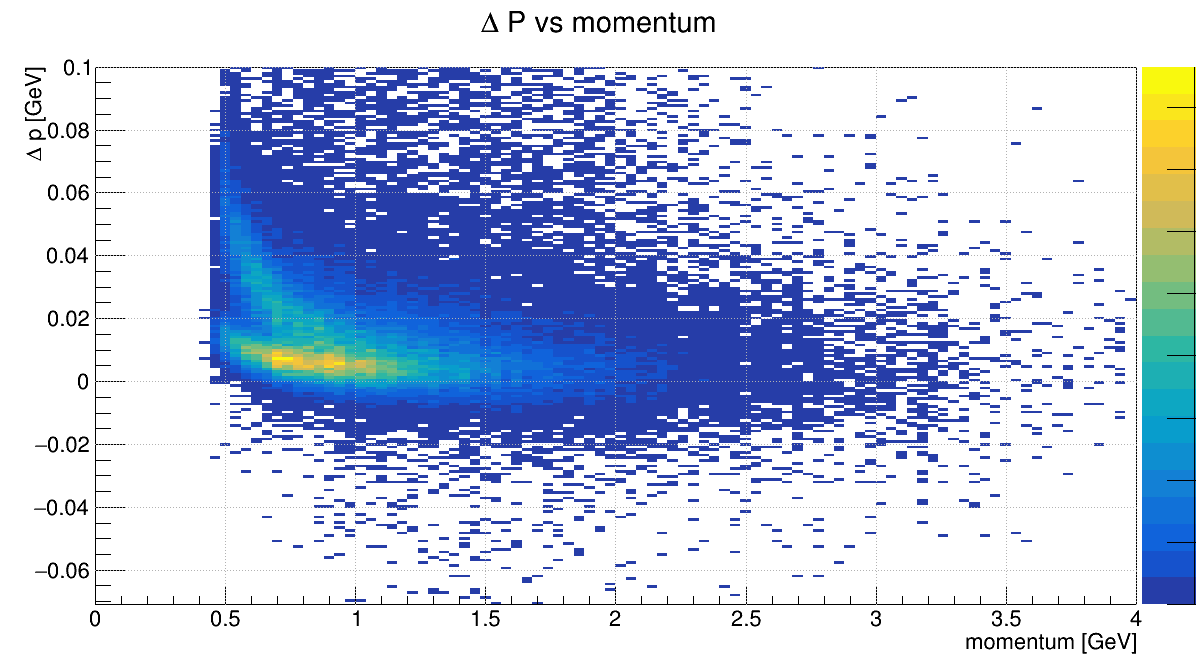

In [4]:
c1 = ROOT.TCanvas("c1","c1",1200,700)
c1.Draw()
h0.Draw("colz")
c1.Print("../pdf/proton.eloss.dpvsp.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../pdf/proton.eloss.dpvstheta.pdf has been created


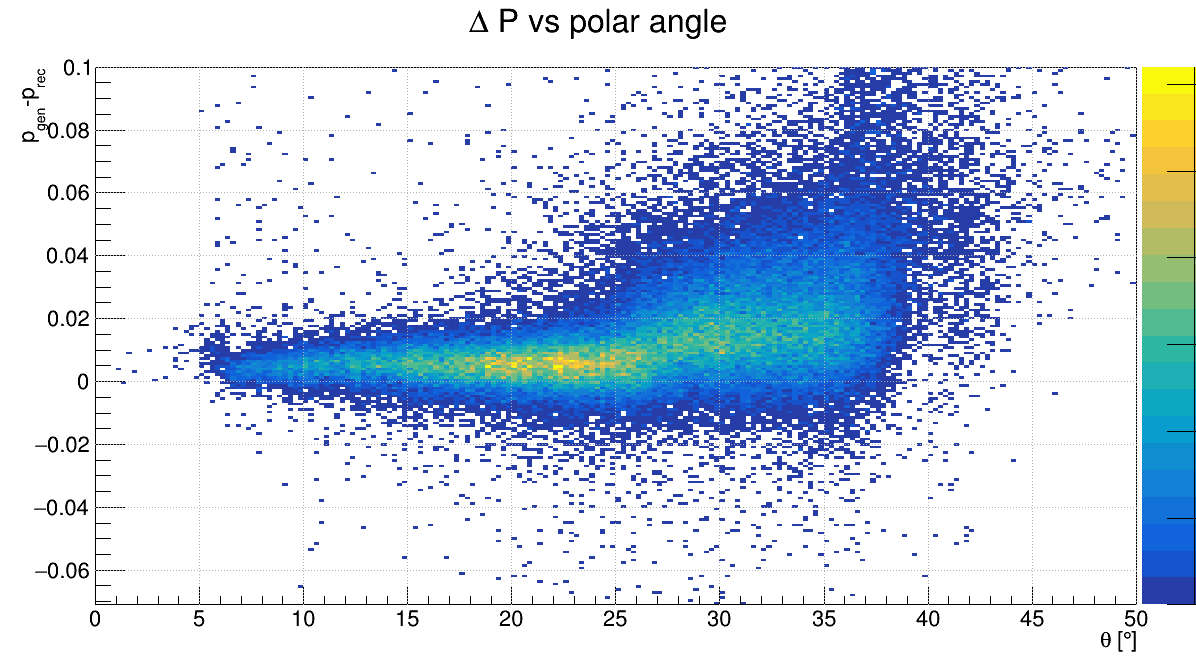

In [5]:
c1 = ROOT.TCanvas("c1","c1",1200,700)
c1.Draw()
hdpth.Draw("colz")
c1.Print("../pdf/proton.eloss.dpvstheta.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


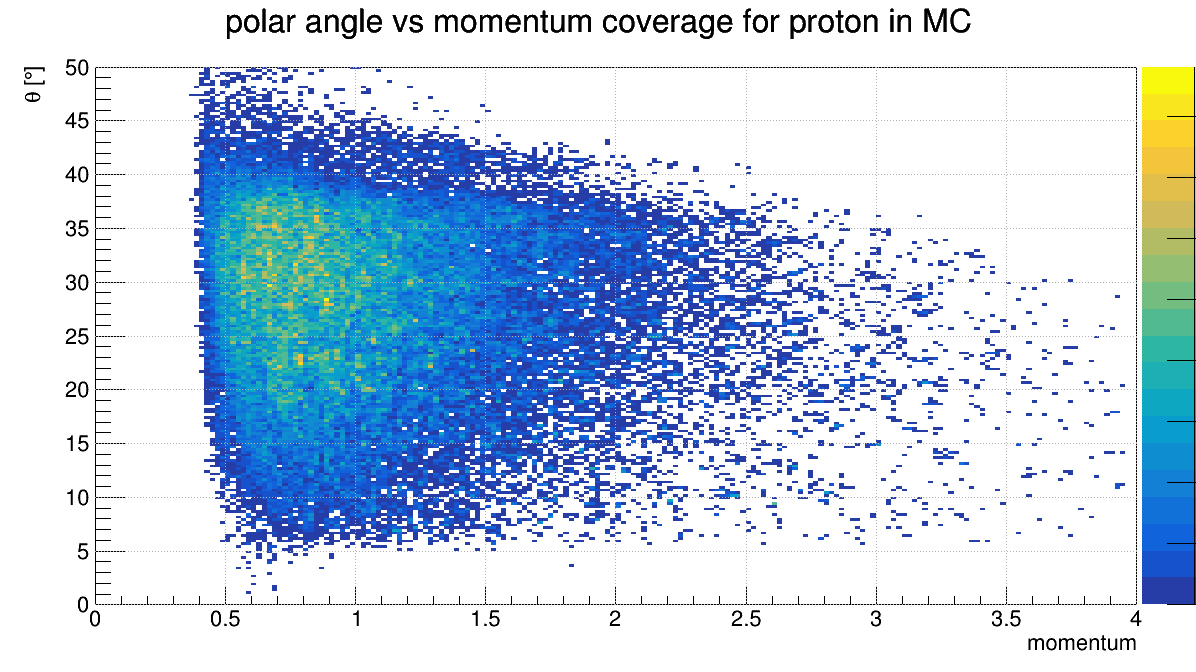

In [6]:
c1 = ROOT.TCanvas("c1","c1",1200,700)
c1.Draw()
hpth.Draw("colz")

In [7]:
f2 = ROOT.TF1("finb<27","expo(0)+pol0(2)",0.4,3)
f2.SetParameters(-2.739, -3.932, 0.002907)
f2.SetLineColor(2)
f3 = ROOT.TF1("finb>27","expo(0)+pol0(2)",0.4,3)
f3.SetLineColor(2)
f3.SetParameters(-1.2, -4.228, 0.007502)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../pdf/proton.eloss.dpvsp.fits.pdf has been created


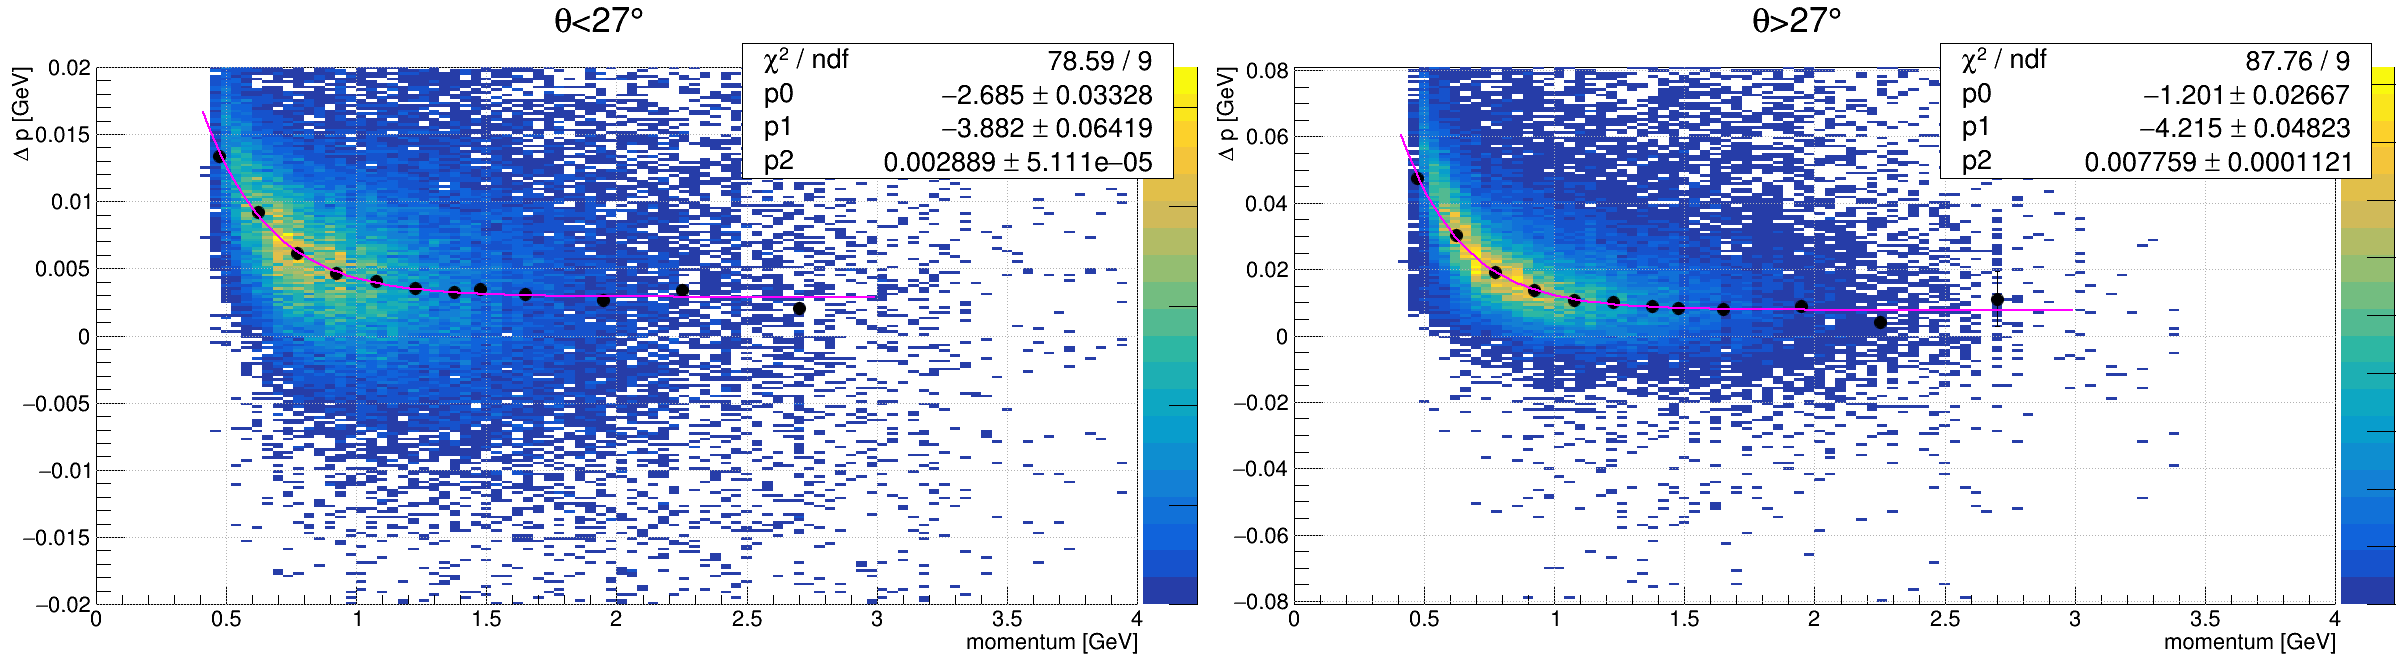

In [8]:
c1 = ROOT.TCanvas("c1","c1",2400,700)
c1.Divide(2,1,0.0001,0.0001)
c1.Draw()


c1.cd(1)
h1.SetTitleOffset(1.1,'y')
h1.Draw("colz")

#grSB0.Draw("P")
#h1.gr.SetMarkerColor(2)
#fPC0.Draw("same")

h1.gr.Draw("P")
h1.gr.SetMarkerSize(1.5)
if 'outb' in fname: f2.Draw("same")


c1.cd(2)
h2.SetTitleOffset(1,'y')
h2.Draw("colz")

#grSB1.Draw("P")
#h2.gr.SetMarkerColor(2)
#fPC1.Draw('same')

h2.gr.Draw("P")
h2.gr.SetMarkerSize(1.5)
if 'outb' in fname: f3.Draw("same")

c1.Print("../pdf/proton.eloss.dpvsp.fits.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../pdf/proton.eloss.dpps0.fits.pdf has been created


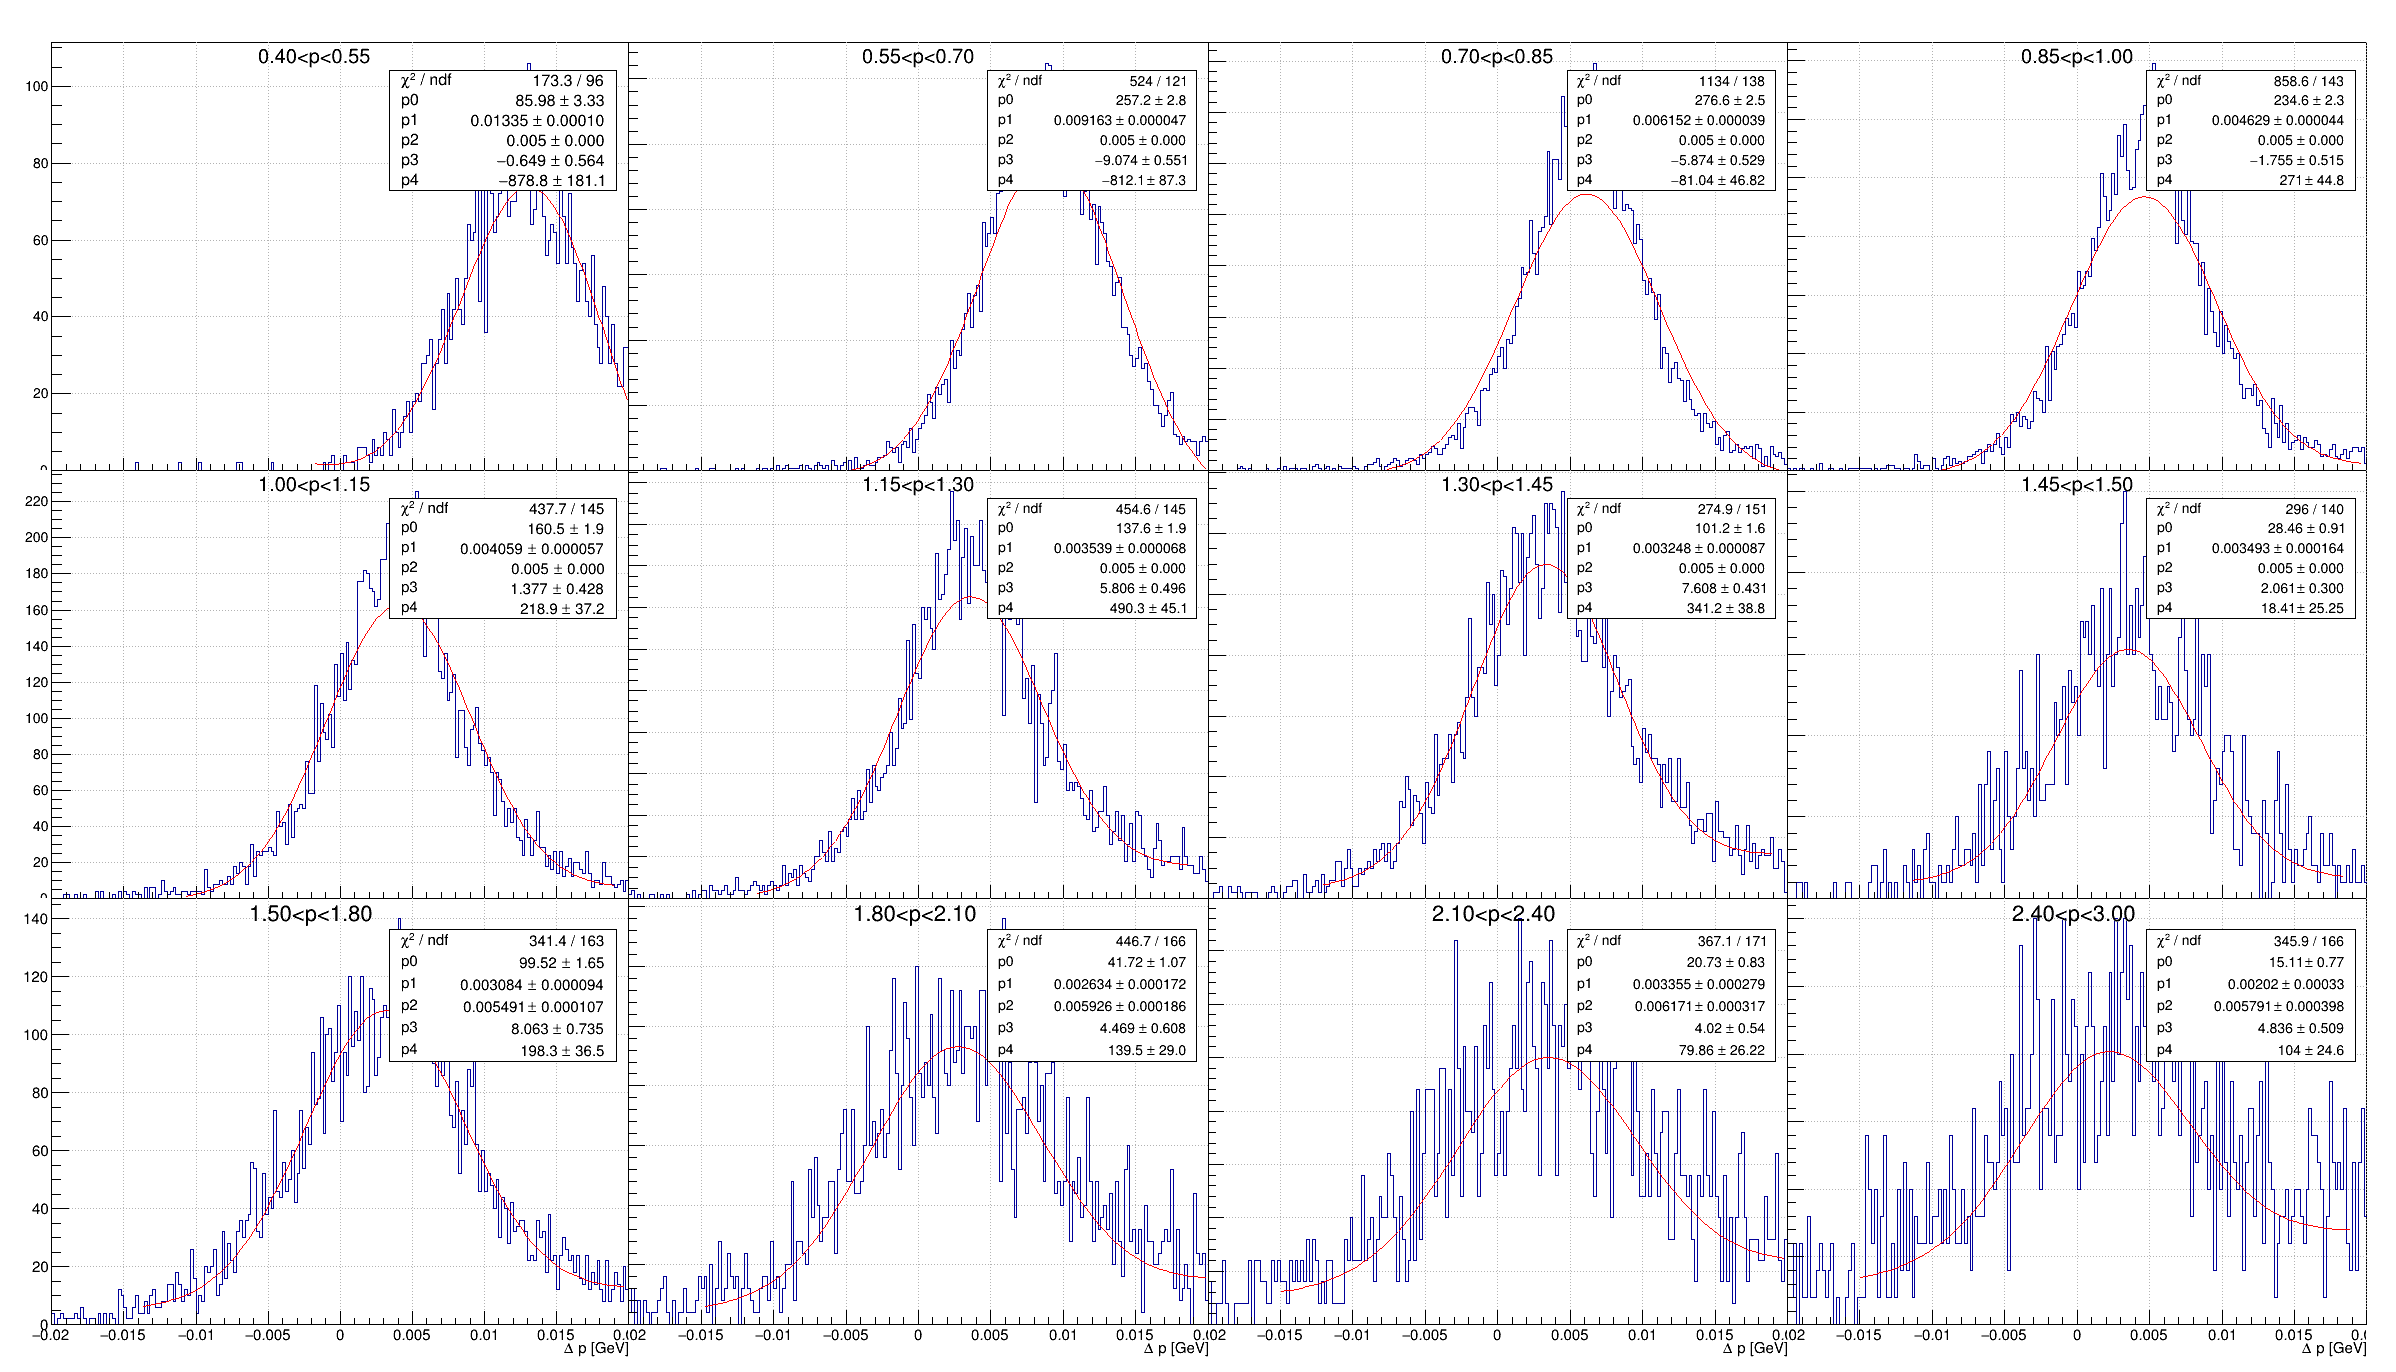

In [9]:
c1 = ROOT.TCanvas("c1","c1",2400,1400)
c1.Divide(4,3,0,0)
c1.Draw()

nlen = len(h1.hys)
for ii in range(nlen):
    c1.cd(ii+1)
    h1.hys[ii].Draw()
c1.Print("../pdf/proton.eloss.dpps0.fits.pdf")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file ../pdf/proton.eloss.dpps1.fits.pdf has been created


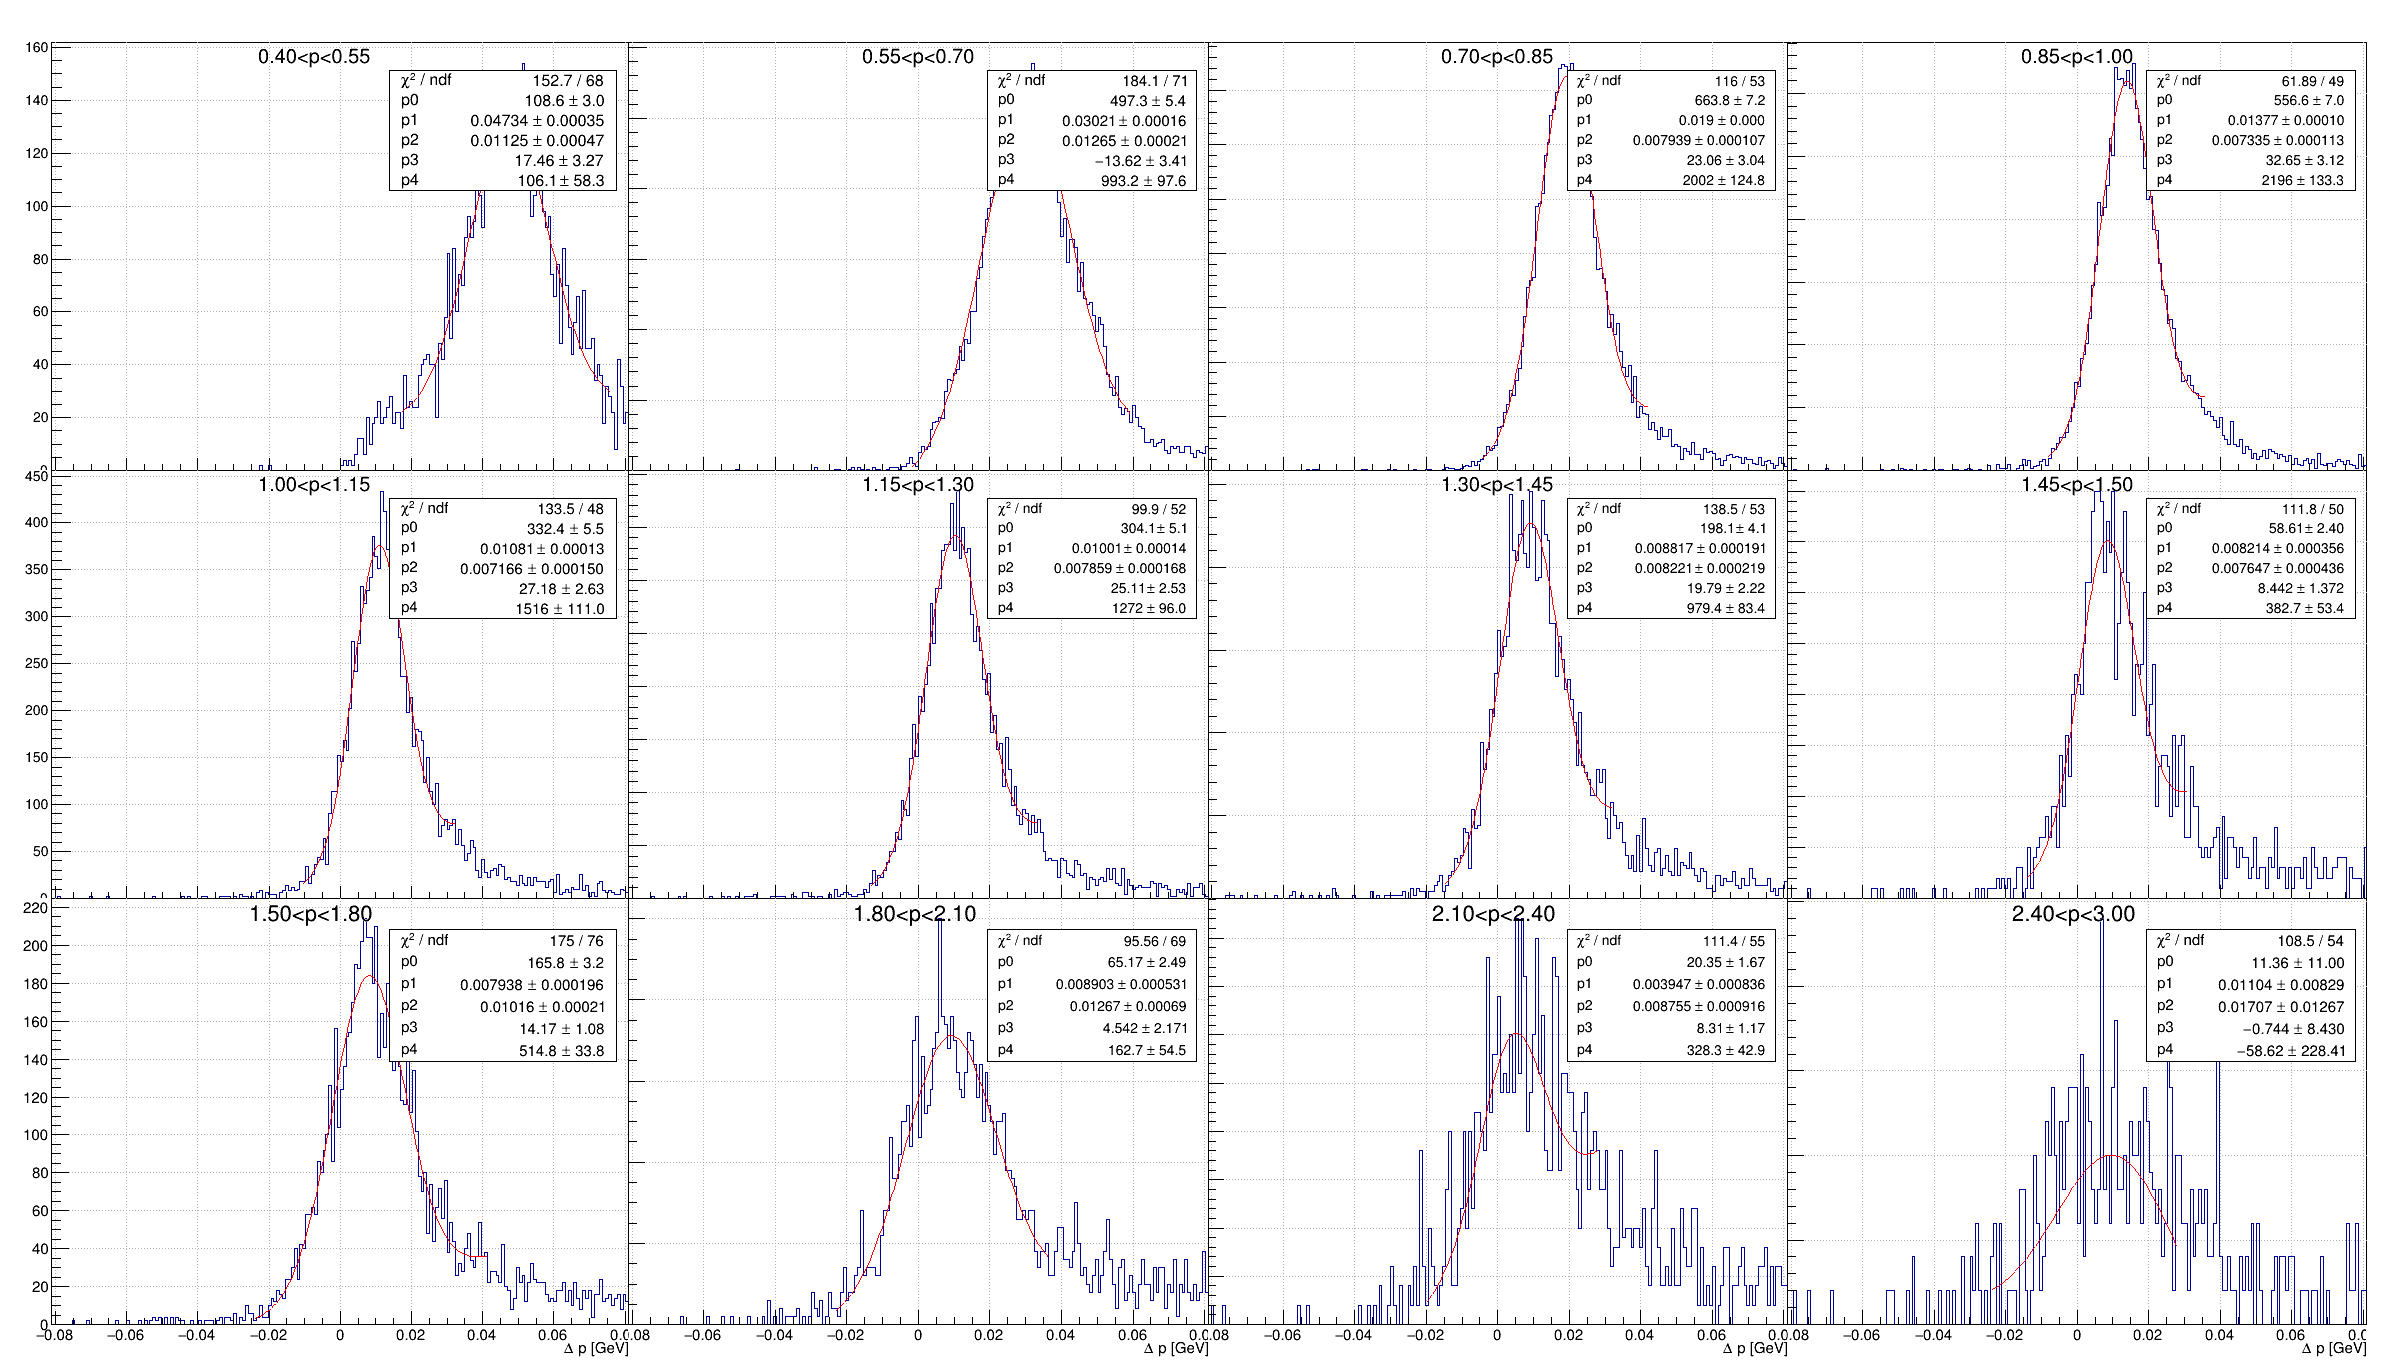

In [10]:
c1 = ROOT.TCanvas("c1","c1",2400,1400)
c1.Divide(4,3,0,0)
c1.Draw()

nlen = len(h2.hys)
for ii in range(nlen):
    c1.cd(ii+1)
    h2.hys[ii].Draw()
c1.Print("../pdf/proton.eloss.dpps1.fits.pdf")

### Inbending and Outbending $\theta<27^\circ$
$dE(p) = e^{-2.739-3.932p} + 0.002907$

------------

### Inbending $\theta>27^\circ$
$dE(p) = e^{-1.2-4.228p} + 0.007502$

-----------

### Outbending $\theta>27^\circ$
$dE(p) = e^{-1.871-3.063p} + 0.007517$

-----------
